In [1]:
from environments import OneDCleanupEnv, CleanupRegion
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from agents import QAgent
import torch

2023-12-05 15:53:35,131	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"cuda available: {torch.cuda.is_available()}")
np.set_printoptions(threshold=np.inf)

cuda available: False


In [3]:

steps_per_episode = 1000
num_agents = 10
agent_ids = [str(i + 1) for i in range(num_agents)]

In [4]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [5]:
gamma = 0.999
epsilon = 1.0
epsilon_decay = 0.99995
epsilon_min = 0.1
lr = 0.0001
batch_size = 32

In [6]:
state_dim = 4
num_action_outputs = 1
action_size = 3

In [7]:
env = OneDCleanupEnv(agent_ids=agent_ids,
                     num_agents=num_agents,
                     area=area,
                     thresholdDepletion=thresholdDepletion,
                     thresholdRestoration=thresholdRestoration,
                     wasteSpawnProbability=wasteSpawnProbability,
                     appleRespawnProbability=appleRespawnProbability,
                     use_randomness=False,
                     dirt_multiplier=dirt_multiplier)
picker_q = QAgent(state_dim=state_dim,
                action_size=action_size,
                num_action_outputs=num_action_outputs,
                gamma=gamma,
                epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                epsilon_min=epsilon_min,
                lr=lr,
                device=device,
                batch_size=batch_size,
                q_layers=[
                    (state_dim, 64),
                    (64, 32),
                    (32, action_size)
                ])
cleaner_q = QAgent(state_dim=state_dim,
                action_size=action_size,
                num_action_outputs=num_action_outputs,
                gamma=gamma,
                epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                epsilon_min=epsilon_min,
                lr=lr,
                device=device,
                batch_size=batch_size,
                q_layers=[
                    (state_dim, 64),
                    (64, 32),
                    (32, action_size)
                ])

In [8]:
ending_ep_rewards = []
num_episodes = 100
steps_per_epsiode = 1000
verbose_episode = num_episodes - 1

In [9]:
max_reward = 0
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")

    states, info = env.reset()

    #print(f"info: {info}")

    prev_assignments = {id: env._agents[id].region for id in agent_ids}

    picker_has_stepped = False
    cleaner_has_stepped = False

    for step in tqdm(range(steps_per_epsiode)):
        num_apples, num_dirt, _, _ = states["coordinator"]
        agent_frequency_in_dirt = num_dirt / (num_apples + num_dirt)
        num_cleaner = round(num_agents * agent_frequency_in_dirt)
        num_picker = num_agents - num_cleaner
        assignments = env.get_greedy_assignments(num_picker, num_cleaner)
        real_num_picker = len([id for id in agent_ids if assignments[id] == CleanupRegion.APPLE])
        real_num_cleaner = len([id for id in agent_ids if assignments[id] == CleanupRegion.WASTE])
        assert real_num_picker == num_picker
        assert real_num_cleaner == num_cleaner
        directions = {}
        for agent_id in agent_ids:
            if assignments[agent_id] != prev_assignments[agent_id]:
                directions[agent_id] = 0
            elif assignments[agent_id] == CleanupRegion.APPLE:
                directions[agent_id] = picker_q.act(np.array(states[agent_id])).flatten()[0] - 1
            else:
                directions[agent_id] = cleaner_q.act(np.array(states[agent_id])).flatten()[0] - 1
        #print(f"actions: {actions}")
        actions = {agent_id: (assignments[agent_id], directions[agent_id]) for agent_id in agent_ids}
        next_states, rewards, dones, _, info = env.step(actions)

        # print('dirt rewards', {agent_id: rewards[agent_id] for agent_id in agent_ids if assignments[agent_id] == CleanupRegion.WASTE})
        # print('apple rewards', {agent_id: rewards[agent_id] for agent_id in agent_ids if assignments[agent_id] == CleanupRegion.APPLE})

        for agent_id in agent_ids:
            if assignments[agent_id] != prev_assignments[agent_id]:
                continue
            elif assignments[agent_id] == CleanupRegion.APPLE:
                picker_q.step(np.array(states[agent_id]), actions[agent_id][1] + 1, rewards[agent_id], np.array(next_states[agent_id]))
                picker_has_stepped = True
            else:
                cleaner_q.step(np.array(states[agent_id]), actions[agent_id][1] + 1, rewards[agent_id], np.array(next_states[agent_id]))
                cleaner_has_stepped = True

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")

        states = next_states

        prev_assignments = assignments

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    print(f"========= End of Episode {episode} =========")

    ending_ep_rewards.append(ending_reward)

    if picker_has_stepped:
        picker_q.scheduler.step()
        picker_has_stepped = False
    if cleaner_has_stepped:
        cleaner_q.scheduler.step()
        cleaner_has_stepped = False

    if ending_reward > max_reward:
        max_reward = ending_reward

========= Episode 0 =========


  2%|▏         | 16/1000 [00:00<00:13, 74.86it/s]

100%|█████████▉| 999/1000 [00:07<00:00, 134.92it/s]


ending reward: 33
========= End of Episode 0 =========
========= Episode 1 =========


100%|█████████▉| 999/1000 [00:07<00:00, 135.31it/s]


ending reward: 62
========= End of Episode 1 =========
========= Episode 2 =========


100%|█████████▉| 999/1000 [00:07<00:00, 139.66it/s]


ending reward: 108
========= End of Episode 2 =========
========= Episode 3 =========


100%|█████████▉| 999/1000 [00:07<00:00, 136.19it/s]


ending reward: 77
========= End of Episode 3 =========
========= Episode 4 =========


100%|█████████▉| 999/1000 [00:07<00:00, 130.94it/s]


ending reward: 98
========= End of Episode 4 =========
========= Episode 5 =========


100%|█████████▉| 999/1000 [00:07<00:00, 142.29it/s]


ending reward: 119
========= End of Episode 5 =========
========= Episode 6 =========


100%|█████████▉| 999/1000 [00:06<00:00, 147.08it/s]


ending reward: 99
========= End of Episode 6 =========
========= Episode 7 =========


100%|█████████▉| 999/1000 [00:06<00:00, 145.77it/s]


ending reward: 130
========= End of Episode 7 =========
========= Episode 8 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.22it/s]


ending reward: 92
========= End of Episode 8 =========
========= Episode 9 =========


100%|█████████▉| 999/1000 [00:06<00:00, 147.46it/s]


ending reward: 99
========= End of Episode 9 =========
========= Episode 10 =========


100%|█████████▉| 999/1000 [00:06<00:00, 146.10it/s]


ending reward: 110
========= End of Episode 10 =========
========= Episode 11 =========


100%|█████████▉| 999/1000 [00:07<00:00, 142.68it/s]


ending reward: 94
========= End of Episode 11 =========
========= Episode 12 =========


100%|█████████▉| 999/1000 [00:06<00:00, 145.52it/s]


ending reward: 107
========= End of Episode 12 =========
========= Episode 13 =========


100%|█████████▉| 999/1000 [00:07<00:00, 142.35it/s]


ending reward: 102
========= End of Episode 13 =========
========= Episode 14 =========


100%|█████████▉| 999/1000 [00:07<00:00, 125.40it/s]


ending reward: 112
========= End of Episode 14 =========
========= Episode 15 =========


100%|█████████▉| 999/1000 [00:07<00:00, 137.33it/s]


ending reward: 97
========= End of Episode 15 =========
========= Episode 16 =========


100%|█████████▉| 999/1000 [00:07<00:00, 136.88it/s]


ending reward: 106
========= End of Episode 16 =========
========= Episode 17 =========


100%|█████████▉| 999/1000 [00:07<00:00, 134.42it/s]


ending reward: 91
========= End of Episode 17 =========
========= Episode 18 =========


100%|█████████▉| 999/1000 [00:06<00:00, 147.69it/s]


ending reward: 121
========= End of Episode 18 =========
========= Episode 19 =========


100%|█████████▉| 999/1000 [00:06<00:00, 144.32it/s]


ending reward: 106
========= End of Episode 19 =========
========= Episode 20 =========


100%|█████████▉| 999/1000 [00:06<00:00, 148.24it/s]


ending reward: 85
========= End of Episode 20 =========
========= Episode 21 =========


100%|█████████▉| 999/1000 [00:08<00:00, 111.87it/s]


ending reward: 97
========= End of Episode 21 =========
========= Episode 22 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.65it/s]


ending reward: 95
========= End of Episode 22 =========
========= Episode 23 =========


100%|█████████▉| 999/1000 [00:08<00:00, 124.05it/s]


ending reward: 99
========= End of Episode 23 =========
========= Episode 24 =========


100%|█████████▉| 999/1000 [00:08<00:00, 123.64it/s]


ending reward: 118
========= End of Episode 24 =========
========= Episode 25 =========


100%|█████████▉| 999/1000 [00:06<00:00, 149.18it/s]


ending reward: 97
========= End of Episode 25 =========
========= Episode 26 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.60it/s]


ending reward: 113
========= End of Episode 26 =========
========= Episode 27 =========


100%|█████████▉| 999/1000 [00:06<00:00, 149.68it/s]


ending reward: 100
========= End of Episode 27 =========
========= Episode 28 =========


100%|█████████▉| 999/1000 [00:06<00:00, 149.24it/s]


ending reward: 99
========= End of Episode 28 =========
========= Episode 29 =========


100%|█████████▉| 999/1000 [00:06<00:00, 154.02it/s]


ending reward: 99
========= End of Episode 29 =========
========= Episode 30 =========


100%|█████████▉| 999/1000 [00:06<00:00, 146.83it/s]


ending reward: 112
========= End of Episode 30 =========
========= Episode 31 =========


100%|█████████▉| 999/1000 [00:06<00:00, 152.83it/s]


ending reward: 102
========= End of Episode 31 =========
========= Episode 32 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.74it/s]


ending reward: 86
========= End of Episode 32 =========
========= Episode 33 =========


100%|█████████▉| 999/1000 [00:06<00:00, 152.59it/s]


ending reward: 118
========= End of Episode 33 =========
========= Episode 34 =========


100%|█████████▉| 999/1000 [00:06<00:00, 155.46it/s]


ending reward: 100
========= End of Episode 34 =========
========= Episode 35 =========


100%|█████████▉| 999/1000 [00:06<00:00, 152.55it/s]


ending reward: 98
========= End of Episode 35 =========
========= Episode 36 =========


100%|█████████▉| 999/1000 [00:06<00:00, 153.77it/s]


ending reward: 90
========= End of Episode 36 =========
========= Episode 37 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.47it/s]


ending reward: 102
========= End of Episode 37 =========
========= Episode 38 =========


100%|█████████▉| 999/1000 [00:06<00:00, 155.55it/s]


ending reward: 103
========= End of Episode 38 =========
========= Episode 39 =========


100%|█████████▉| 999/1000 [00:06<00:00, 144.91it/s]


ending reward: 129
========= End of Episode 39 =========
========= Episode 40 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.19it/s]


ending reward: 95
========= End of Episode 40 =========
========= Episode 41 =========


100%|█████████▉| 999/1000 [00:06<00:00, 147.90it/s]


ending reward: 99
========= End of Episode 41 =========
========= Episode 42 =========


100%|█████████▉| 999/1000 [00:06<00:00, 154.84it/s]


ending reward: 106
========= End of Episode 42 =========
========= Episode 43 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.80it/s]


ending reward: 88
========= End of Episode 43 =========
========= Episode 44 =========


100%|█████████▉| 999/1000 [00:06<00:00, 148.85it/s]


ending reward: 119
========= End of Episode 44 =========
========= Episode 45 =========


100%|█████████▉| 999/1000 [00:07<00:00, 137.16it/s]


ending reward: 109
========= End of Episode 45 =========
========= Episode 46 =========


100%|█████████▉| 999/1000 [00:06<00:00, 145.38it/s]


ending reward: 95
========= End of Episode 46 =========
========= Episode 47 =========


100%|█████████▉| 999/1000 [00:06<00:00, 145.93it/s]


ending reward: 105
========= End of Episode 47 =========
========= Episode 48 =========


100%|█████████▉| 999/1000 [00:07<00:00, 141.84it/s]


ending reward: 114
========= End of Episode 48 =========
========= Episode 49 =========


100%|█████████▉| 999/1000 [00:06<00:00, 148.03it/s]


ending reward: 114
========= End of Episode 49 =========
========= Episode 50 =========


100%|█████████▉| 999/1000 [00:06<00:00, 152.96it/s]


ending reward: 103
========= End of Episode 50 =========
========= Episode 51 =========


100%|█████████▉| 999/1000 [00:07<00:00, 131.57it/s]


ending reward: 100
========= End of Episode 51 =========
========= Episode 52 =========


100%|█████████▉| 999/1000 [00:07<00:00, 128.46it/s]


ending reward: 86
========= End of Episode 52 =========
========= Episode 53 =========


100%|█████████▉| 999/1000 [00:07<00:00, 141.61it/s]


ending reward: 114
========= End of Episode 53 =========
========= Episode 54 =========


100%|█████████▉| 999/1000 [00:08<00:00, 123.14it/s]


ending reward: 102
========= End of Episode 54 =========
========= Episode 55 =========


100%|█████████▉| 999/1000 [02:58<00:00,  5.58it/s] 


ending reward: 103
========= End of Episode 55 =========
========= Episode 56 =========


100%|█████████▉| 999/1000 [00:07<00:00, 138.10it/s]


ending reward: 113
========= End of Episode 56 =========
========= Episode 57 =========


100%|█████████▉| 999/1000 [00:07<00:00, 138.47it/s]


ending reward: 103
========= End of Episode 57 =========
========= Episode 58 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.15it/s]


ending reward: 119
========= End of Episode 58 =========
========= Episode 59 =========


100%|█████████▉| 999/1000 [03:30<00:00,  4.74it/s] 


ending reward: 100
========= End of Episode 59 =========
========= Episode 60 =========


100%|█████████▉| 999/1000 [00:06<00:00, 151.10it/s]


ending reward: 101
========= End of Episode 60 =========
========= Episode 61 =========


100%|█████████▉| 999/1000 [00:07<00:00, 133.62it/s]


ending reward: 116
========= End of Episode 61 =========
========= Episode 62 =========


100%|█████████▉| 999/1000 [00:08<00:00, 117.56it/s]


ending reward: 98
========= End of Episode 62 =========
========= Episode 63 =========


100%|█████████▉| 999/1000 [01:55<00:00,  8.68it/s] 


ending reward: 101
========= End of Episode 63 =========
========= Episode 64 =========


100%|█████████▉| 999/1000 [00:07<00:00, 138.66it/s]


ending reward: 102
========= End of Episode 64 =========
========= Episode 65 =========


100%|█████████▉| 999/1000 [00:06<00:00, 144.95it/s]


ending reward: 101
========= End of Episode 65 =========
========= Episode 66 =========


100%|█████████▉| 999/1000 [00:06<00:00, 147.34it/s]


ending reward: 116
========= End of Episode 66 =========
========= Episode 67 =========


100%|█████████▉| 999/1000 [00:06<00:00, 150.97it/s]


ending reward: 101
========= End of Episode 67 =========
========= Episode 68 =========


100%|█████████▉| 999/1000 [00:57<00:00, 17.27it/s] 


ending reward: 107
========= End of Episode 68 =========
========= Episode 69 =========


100%|█████████▉| 999/1000 [01:31<00:00, 10.92it/s] 


ending reward: 120
========= End of Episode 69 =========
========= Episode 70 =========


100%|█████████▉| 999/1000 [00:06<00:00, 150.27it/s]


ending reward: 115
========= End of Episode 70 =========
========= Episode 71 =========


100%|█████████▉| 999/1000 [00:56<00:00, 17.71it/s] 


ending reward: 113
========= End of Episode 71 =========
========= Episode 72 =========


100%|█████████▉| 999/1000 [01:00<00:00, 16.61it/s] 


ending reward: 109
========= End of Episode 72 =========
========= Episode 73 =========


100%|█████████▉| 999/1000 [00:06<00:00, 149.27it/s]


ending reward: 96
========= End of Episode 73 =========
========= Episode 74 =========


100%|█████████▉| 999/1000 [17:55<00:01,  1.08s/it]  


ending reward: 98
========= End of Episode 74 =========
========= Episode 75 =========


100%|█████████▉| 999/1000 [16:11<00:00,  1.03it/s]  


ending reward: 126
========= End of Episode 75 =========
========= Episode 76 =========


100%|█████████▉| 999/1000 [11:38<00:00,  1.43it/s]  


ending reward: 115
========= End of Episode 76 =========
========= Episode 77 =========


100%|█████████▉| 999/1000 [17:13<00:01,  1.03s/it] 


ending reward: 111
========= End of Episode 77 =========
========= Episode 78 =========


100%|█████████▉| 999/1000 [00:06<00:00, 149.25it/s]


ending reward: 101
========= End of Episode 78 =========
========= Episode 79 =========


100%|█████████▉| 999/1000 [00:59<00:00, 16.74it/s] 


ending reward: 96
========= End of Episode 79 =========
========= Episode 80 =========


100%|█████████▉| 999/1000 [01:01<00:00, 16.21it/s] 


ending reward: 96
========= End of Episode 80 =========
========= Episode 81 =========


100%|█████████▉| 999/1000 [00:07<00:00, 133.56it/s]


ending reward: 92
========= End of Episode 81 =========
========= Episode 82 =========


100%|█████████▉| 999/1000 [00:46<00:00, 21.43it/s] 


ending reward: 112
========= End of Episode 82 =========
========= Episode 83 =========


100%|█████████▉| 999/1000 [00:52<00:00, 18.99it/s] 


ending reward: 117
========= End of Episode 83 =========
========= Episode 84 =========


100%|█████████▉| 999/1000 [00:06<00:00, 152.47it/s]


ending reward: 81
========= End of Episode 84 =========
========= Episode 85 =========


100%|█████████▉| 999/1000 [00:56<00:00, 17.63it/s] 


ending reward: 126
========= End of Episode 85 =========
========= Episode 86 =========


100%|█████████▉| 999/1000 [15:29<00:00,  1.07it/s]  


ending reward: 119
========= End of Episode 86 =========
========= Episode 87 =========


100%|█████████▉| 999/1000 [00:06<00:00, 144.30it/s]


ending reward: 84
========= End of Episode 87 =========
========= Episode 88 =========


100%|█████████▉| 999/1000 [02:11<00:00,  7.59it/s] 


ending reward: 108
========= End of Episode 88 =========
========= Episode 89 =========


100%|█████████▉| 999/1000 [00:08<00:00, 119.65it/s]


ending reward: 103
========= End of Episode 89 =========
========= Episode 90 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.50it/s]


ending reward: 84
========= End of Episode 90 =========
========= Episode 91 =========


100%|█████████▉| 999/1000 [00:08<00:00, 123.11it/s]


ending reward: 124
========= End of Episode 91 =========
========= Episode 92 =========


100%|█████████▉| 999/1000 [00:06<00:00, 145.44it/s]


ending reward: 120
========= End of Episode 92 =========
========= Episode 93 =========


100%|█████████▉| 999/1000 [00:06<00:00, 145.12it/s]


ending reward: 110
========= End of Episode 93 =========
========= Episode 94 =========


100%|█████████▉| 999/1000 [00:06<00:00, 145.53it/s]


ending reward: 106
========= End of Episode 94 =========
========= Episode 95 =========


100%|█████████▉| 999/1000 [00:07<00:00, 134.00it/s]


ending reward: 119
========= End of Episode 95 =========
========= Episode 96 =========


100%|█████████▉| 999/1000 [00:07<00:00, 140.58it/s]


ending reward: 101
========= End of Episode 96 =========
========= Episode 97 =========


100%|█████████▉| 999/1000 [00:10<00:00, 94.52it/s] 


ending reward: 103
========= End of Episode 97 =========
========= Episode 98 =========


100%|█████████▉| 999/1000 [00:12<00:00, 79.80it/s] 


ending reward: 118
========= End of Episode 98 =========
========= Episode 99 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.20it/s]

ending reward: 104
========= End of Episode 99 =========


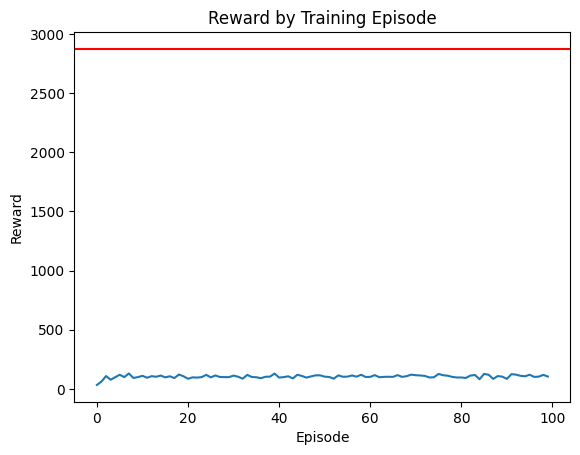

In [10]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.axhline(y=2875.1, color='r', linestyle='-')
plt.show()

In [11]:
num_episodes = 20
verbose_episode = num_episodes - 1
test_stats = []
picker_q.q_network.eval()
cleaner_q.q_network.eval()
for episode in range(num_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })
    
    print(f"========= Episode {episode} =========")

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #print(f"info: {info}")

    prev_assignments = {id: env._agents[id].region for id in agent_ids}

    for step in tqdm(range(steps_per_episode)):
        num_apples, num_dirt, _, _ = states["coordinator"]
        agent_frequency_in_dirt = num_dirt / (num_apples + num_dirt)
        num_cleaner = round(num_agents * agent_frequency_in_dirt)
        num_picker = num_agents - num_cleaner
        assignments = env.get_greedy_assignments(num_picker, num_cleaner)
        directions = {}
        for agent_id in agent_ids:
            if assignments[agent_id] != prev_assignments[agent_id]:
                directions[agent_id] = 0
            elif assignments[agent_id] == CleanupRegion.APPLE:
                directions[agent_id] = picker_q.act(np.array(states[agent_id])).flatten()[0] - 1
            else:
                directions[agent_id] = cleaner_q.act(np.array(states[agent_id])).flatten()[0] - 1
        #print(f"actions: {actions}")
        actions = {agent_id: (assignments[agent_id], directions[agent_id]) for agent_id in agent_ids}
        next_states, reward, dones, _, info = env.step(actions)
        
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])

        states = next_states
        prev_assignments = assignments

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = ending_reward

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")



========= Episode 0 =========


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [00:00<00:00, 1240.56it/s]


ending reward: 110
========= End of Episode 0 =========
========= Episode 1 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1591.12it/s]


ending reward: 97
========= End of Episode 1 =========
========= Episode 2 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1559.94it/s]


ending reward: 111
========= End of Episode 2 =========
========= Episode 3 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1594.89it/s]


ending reward: 90
========= End of Episode 3 =========
========= Episode 4 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1598.11it/s]


ending reward: 115
========= End of Episode 4 =========
========= Episode 5 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1582.87it/s]


ending reward: 105
========= End of Episode 5 =========
========= Episode 6 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1415.74it/s]


ending reward: 111
========= End of Episode 6 =========
========= Episode 7 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1660.81it/s]


ending reward: 123
========= End of Episode 7 =========
========= Episode 8 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1641.48it/s]


ending reward: 123
========= End of Episode 8 =========
========= Episode 9 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1373.27it/s]


ending reward: 104
========= End of Episode 9 =========
========= Episode 10 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1587.39it/s]


ending reward: 101
========= End of Episode 10 =========
========= Episode 11 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1620.20it/s]


ending reward: 119
========= End of Episode 11 =========
========= Episode 12 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1514.77it/s]


ending reward: 118
========= End of Episode 12 =========
========= Episode 13 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1635.25it/s]


ending reward: 105
========= End of Episode 13 =========
========= Episode 14 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1644.58it/s]


ending reward: 92
========= End of Episode 14 =========
========= Episode 15 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1605.59it/s]


ending reward: 100
========= End of Episode 15 =========
========= Episode 16 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1390.85it/s]


ending reward: 118
========= End of Episode 16 =========
========= Episode 17 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1658.39it/s]


ending reward: 115
========= End of Episode 17 =========
========= Episode 18 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1439.19it/s]


ending reward: 94
========= End of Episode 18 =========
========= Episode 19 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1535.12it/s]

ending reward: 99
========= End of Episode 19 =========


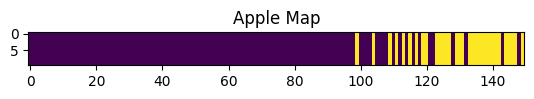

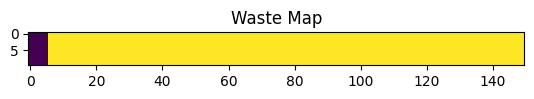

/Users/gabeguralnick/git/social_reinforcement_learning/environments/one_d_cleanup_env.py:481: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  apple_agent_map[np.where(apple_agent_map == id)] = 1


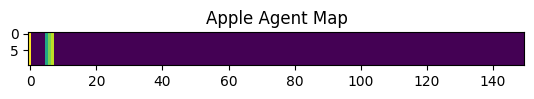

/Users/gabeguralnick/git/social_reinforcement_learning/environments/one_d_cleanup_env.py:491: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  waste_agent_map[np.where(waste_agent_map == id)] = 1


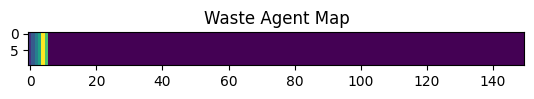

In [12]:
env.render()

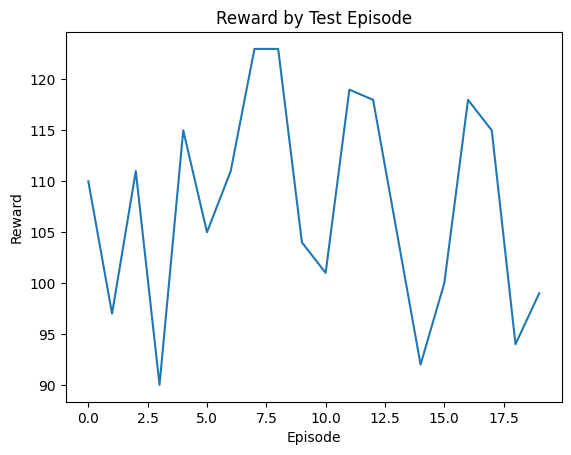

Average reward: 107.5


In [13]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.show()
print(f"Average reward: {np.mean([stat['total_reward'] for stat in test_stats])}")

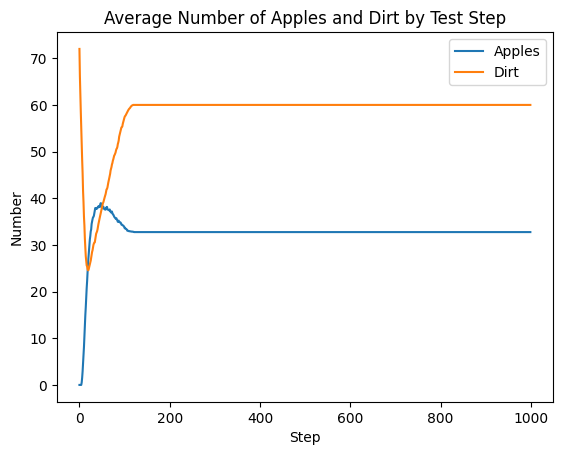

In [14]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

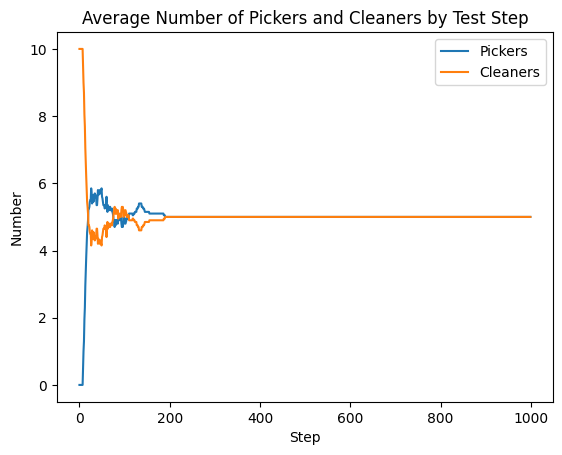

In [15]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

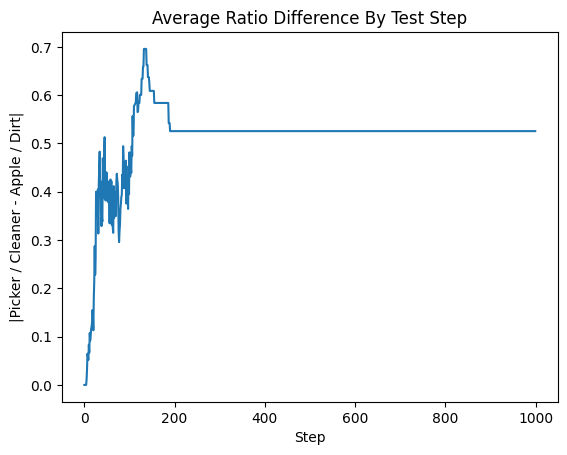

In [22]:
plt.figure()
plt.title('Average Ratio Difference By Test Step')
plt.xlabel('Step')
plt.ylabel('|Picker / Cleaner - Apple / Dirt|')
avg_ratio_diff = []
ratio_steps = []
for i in range(steps_per_episode):
    ratio_diff = []
    for stat in test_stats:
        if stat['num_dirt'][i] == 0 or stat['cleaners'][i] == 0:
            continue
        ratio_diff.append(abs(stat['pickers'][i] / stat['cleaners'][i] - stat['num_apples'][i] / stat['num_dirt'][i]))
    if len(ratio_diff) == 0:
        continue
    avg_ratio_diff.append(np.mean(ratio_diff))
    ratio_steps.append(i)
plt.plot(ratio_steps, avg_ratio_diff)
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.1111111111111111, 0.1111111111111111, 0.0, 0.0, 0.0, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.0, 0.1111111111111111, 0.1111111111111111,

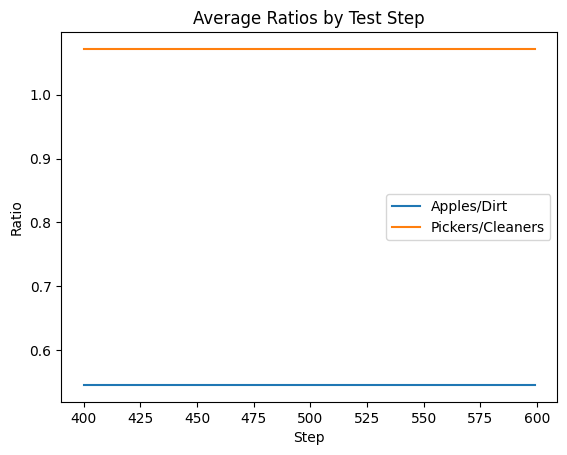

In [21]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        print(picker_cleaner, np.mean(picker_cleaner))
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps[400:600], avg_apple_dirt_ratios[400:600], label="Apples/Dirt")
plt.plot(picker_cleaner_steps[400:600], avg_picker_cleaner_ratios[400:600], label="Pickers/Cleaners")
plt.legend()
plt.show()

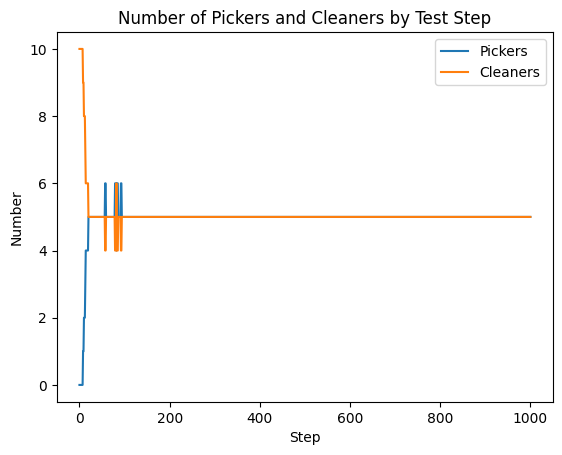

In [17]:
plt.figure()
plt.title("Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
episode = test_stats[0]
plt.plot(episode['pickers'], label="Pickers")
plt.plot(episode['cleaners'], label="Cleaners")
plt.legend()
plt.show()

average picker cleaner ratio 0.9900773829345257
average apple dirt ratio 0.6526860204629399


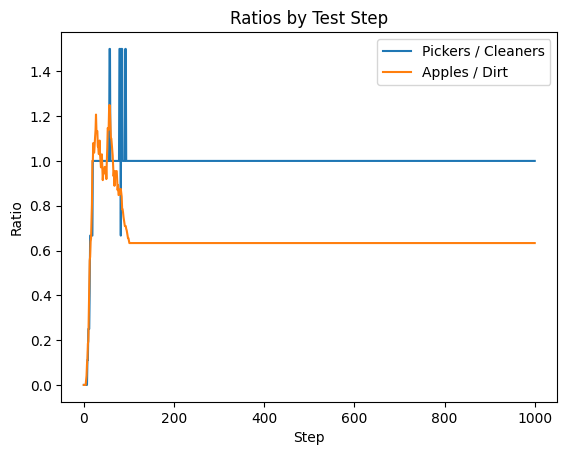

In [18]:
plt.figure()
plt.title("Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
episode = test_stats[0]
#plt.plot([episode['pickers'][i] / (episode['cleaners'][i] + 1e-1) for i in range(len(episode['pickers']))])

picker_cleaner_ratios = []
picker_cleaner_steps = []
for i, (num_pickers, num_cleaners) in enumerate(zip(episode['pickers'], episode['cleaners'])):
    if num_cleaners > 0:
        picker_cleaner_ratios.append(num_pickers / num_cleaners)
        picker_cleaner_steps.append(i)
print('average picker cleaner ratio', np.mean(picker_cleaner_ratios))
plt.plot(picker_cleaner_steps, picker_cleaner_ratios, label='Pickers / Cleaners')

apple_dirt_ratios = []
apple_dirt_steps = []
for i, (num_apples, num_dirt) in enumerate(zip(episode['num_apples'], episode['num_dirt'])):
    if num_dirt > 0:
        apple_dirt_ratios.append(num_apples / num_dirt)
        apple_dirt_steps.append(i)
plt.plot(apple_dirt_steps, apple_dirt_ratios, label='Apples / Dirt')
print('average apple dirt ratio', np.mean(apple_dirt_ratios))
plt.legend()
plt.show()